Imports and Setup

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style for plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded successfully!")

Libraries loaded successfully!


Load Data

In [ ]:
# Load the dataset
file_path = "../data/interim/pakistan_district_climate_history.csv"
print(f"📂 Loading data from: {file_path}")

df = pd.read_csv(file_path)
df.head()

📂 Loading data from: ../data/processed/pakistan_district_climate_history.csv


,time,temp_2m,dew_point,tp,wind_u,wind_v,solar_rad,number,expver,district_name
0,2015-04-01 00:00:00,282.30640,279.75980,1.330937e-02,-1.608655,-0.909447,13252956.0,0,1,Abbottabad
1,2015-04-01 00:00:00,286.43408,285.84006,2.228624e-02,0.222826,-0.999734,10255635.0,0,1,Adam Khel
2,2015-04-01 00:00:00,288.20413,287.50647,1.634783e-02,-0.307827,-1.264785,13133206.0,0,1,Attok
3,2015-04-01 00:00:00,292.37988,288.89010,1.476699e-06,1.284068,0.975949,25950052.0,0,1,Awaran
4,2015-04-01 00:00:00,294.38907,293.39390,8.523459e-07,2.797036,1.455528,25496864.0,0,1,Badin


Ghost columns like number and experver will be dealt with in preprocessing step. expver stands for "Experiment Version". Sometimes ERA5 mixes old data (1) with new preliminary data (5), creating duplicates. The data is messy (as expected) but structurally sound

Useful Components Analysis

In [46]:
# Convert 'time' to datetime objects (Crucial for time-series analysis)
df['time'] = pd.to_datetime(df['time'])

# Extract useful time components for analysis
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['hour'] = df['time'].dt.hour

print(f"   Loaded {len(df):,} rows.")
print(f"   Date Range: {df['time'].min()} to {df['time'].max()}")
print(f"   Columns: {list(df.columns)}")
display(df.head())


   Loaded 5,961,600 rows.
   Date Range: 2015-04-01 00:00:00 to 2024-09-30 23:00:00
   Columns: ['time', 'temp_2m', 'dew_point', 'tp', 'wind_u', 'wind_v', 'solar_rad', 'number', 'expver', 'district_name', 'year', 'month', 'hour']


,time,temp_2m,dew_point,tp,wind_u,wind_v,solar_rad,number,expver,district_name,year,month,hour
0,2015-04-01,282.30640,279.75980,1.330937e-02,-1.608655,-0.909447,13252956.0,0,1,Abbottabad,2015,4,0
1,2015-04-01,286.43408,285.84006,2.228624e-02,0.222826,-0.999734,10255635.0,0,1,Adam Khel,2015,4,0
2,2015-04-01,288.20413,287.50647,1.634783e-02,-0.307827,-1.264785,13133206.0,0,1,Attok,2015,4,0
3,2015-04-01,292.37988,288.89010,1.476699e-06,1.284068,0.975949,25950052.0,0,1,Awaran,2015,4,0
4,2015-04-01,294.38907,293.39390,8.523459e-07,2.797036,1.455528,25496864.0,0,1,Badin,2015,4,0


Structural Integrity Check

In [47]:
print("--- 1. STRUCTURAL HEALTH CHECK ---")

# A. Missing Values
missing = df.isnull().sum()
print("\nMissing Values per Column:")
print(missing[missing > 0])

# B. Duplicate Check (ERA5 expver artifacts)
# If 'expver' or 'number' columns exist, they indicate duplicate versions of data
if 'expver' in df.columns or 'number' in df.columns:
    print("\n 'expver' or 'number' column found. Potential duplicates exist.")
    print(df['expver'].value_counts())
else:
    print("\nNo 'expver' artifacts found. Data structure looks clean.")

# C. District Count
num_districts = df['district_name'].nunique()
print(f"\nDistricts Found: {num_districts}")

--- 1. STRUCTURAL HEALTH CHECK ---

Missing Values per Column:
Series([], dtype: int64)

 'expver' or 'number' column found. Potential duplicates exist.
expver
1    5961600
Name: count, dtype: int64

Districts Found: 138


Best approach is likely to just drop these columns

Physics Check

In [48]:
print("--- 2. PHYSICS CHECK: TEMPERATURE ---")

# Check Mean Temperature
mean_temp = df['temp_2m'].mean()
print(f"Mean Temperature: {mean_temp:.2f}")

# Logic to detect unit
if mean_temp > 200:
    print(" CONCLUSION: Data is in KELVIN. (Need to subtract 273.15 in Preprocessing)")
else:
    print(" CONCLUSION: Data is in CELSIUS.")

--- 2. PHYSICS CHECK: TEMPERATURE ---
Mean Temperature: 299.94
 CONCLUSION: Data is in KELVIN. (Need to subtract 273.15 in Preprocessing)


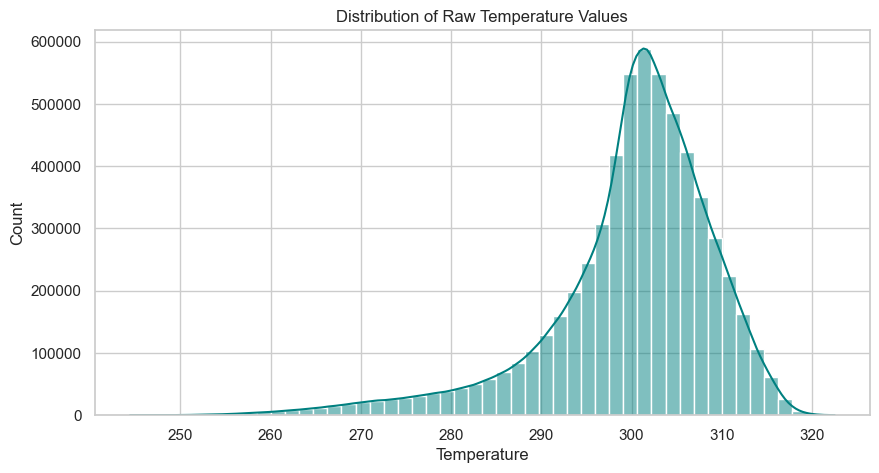

In [49]:
# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(df['temp_2m'], bins=50, kde=True, color="teal")
plt.title("Distribution of Raw Temperature Values")
plt.xlabel("Temperature")
plt.show()

Temperatures nearing 50C is expected for Pakistan

--- 3. PHYSICS CHECK: SOLAR RADIATION ---


C:\Users\Rayyan Tech\AppData\Local\Temp\ipykernel_16812\2707985090.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


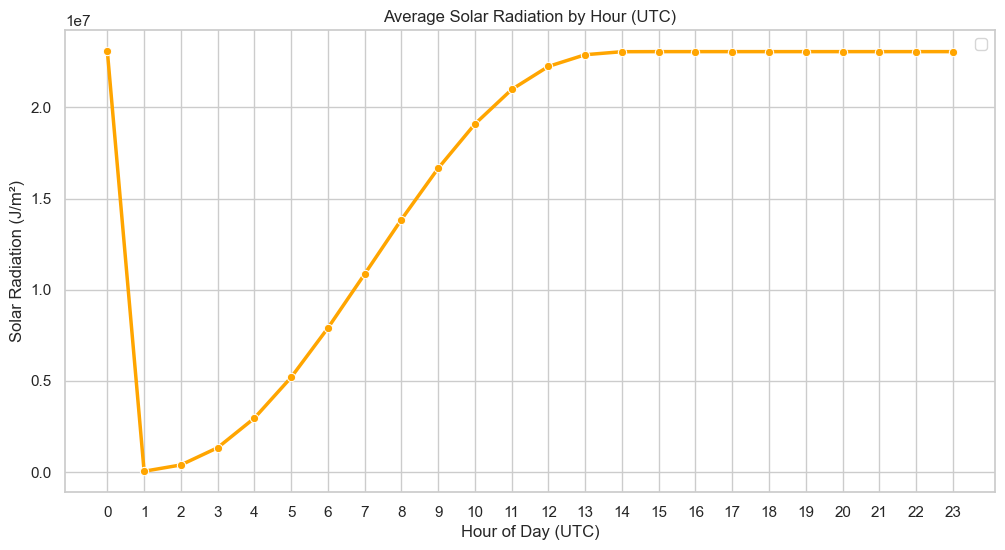

In [50]:
print("--- 3. PHYSICS CHECK: SOLAR RADIATION ---")

# Group by Hour to see the daily cycle
hourly_solar = df.groupby('hour')['solar_rad'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_solar.index, y=hourly_solar.values, marker="o", color="orange", linewidth=2.5)
plt.title("Average Solar Radiation by Hour (UTC)")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("Solar Radiation (J/m²)")
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.show()

In [51]:
# Quick calculation
hour_0_val = hourly_solar.loc[0]
hour_12_val = hourly_solar.loc[12]
print(f"Avg Radiation at 00:00: {hour_0_val:,.0f}")
print(f"Avg Radiation at 12:00: {hour_12_val:,.0f}")

if hour_0_val > hour_12_val:
    print("ANOMALY CONFIRMED: 00:00 UTC is strangely high. Likely 24h accumulation reset.")

Avg Radiation at 00:00: 23,083,143
Avg Radiation at 12:00: 22,252,157
ANOMALY CONFIRMED: 00:00 UTC is strangely high. Likely 24h accumulation reset.


Spatial Validation

--- 4. SPATIAL CHECK: THE 'JACOBABAD TEST' ---


C:\Users\Rayyan Tech\AppData\Local\Temp\ipykernel_16812\668205140.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hottest_districts.values, y=hottest_districts.index, palette="hot")


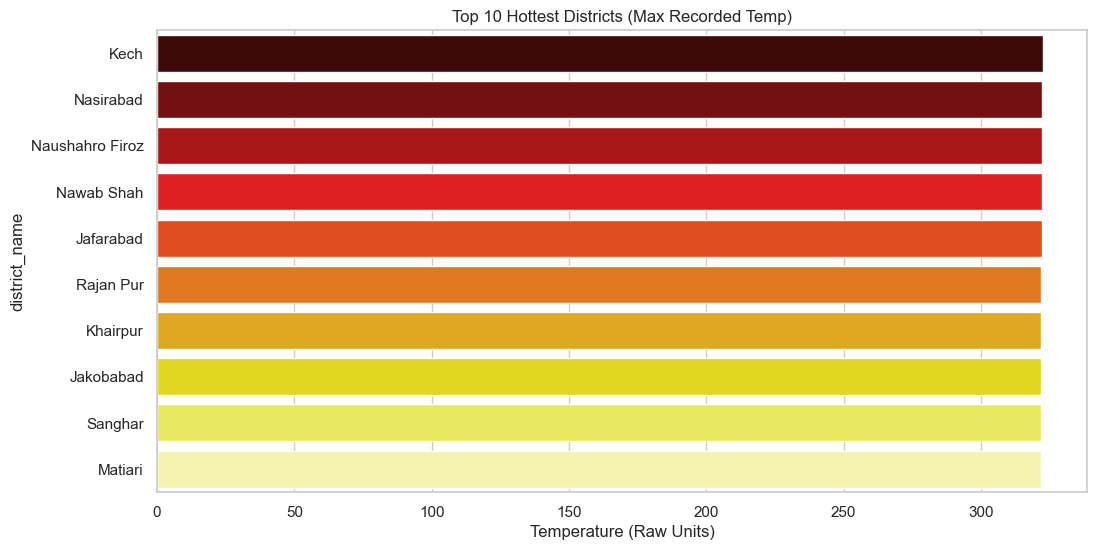

Top 5 Hottest Districts:
district_name
Kech               322.51468
Nasirabad          322.18762
Naushahro Firoz    322.18594
Nawab Shah         322.13052
Jafarabad          322.11480
Name: temp_2m, dtype: float64


In [52]:
print("--- 4. SPATIAL CHECK: THE 'JACOBABAD TEST' ---")

# Find the hottest districts based on Maximum recorded temperature
hottest_districts = df.groupby('district_name')['temp_2m'].max().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=hottest_districts.values, y=hottest_districts.index, palette="hot")
plt.title("Top 10 Hottest Districts (Max Recorded Temp)")
plt.xlabel("Temperature (Raw Units)")
plt.show()

print("Top 5 Hottest Districts:")
print(hottest_districts.head(5))

In [53]:
for d in df['district_name'].unique():
    print(d)

Abbottabad
Adam Khel
Attok
Awaran
Badin
Bagh
Bahawalnagar
Bahawalpur
Bajaur
Bannu
Barkhan
Battagram
Bhakkar
Bhimber
Bhittani
Bolan
Buner
Chagai
Chakwal
Charsadda
Chilas
Chitral
Dadu
Dera Bugti
Dera Ghazi Kha
Dera Ismail Khan
Dir
Disputed Area 1
Faisalabad
Ghotki
Gilgit
Gilgit (Tribal Territory)
Gujarat
Gujranwala 1
Gujranwala 2
Gujrat
Gwadar
Hafizabad
Hangu
Haripur
Hyderabad
Islamabad
Jafarabad
Jakobabad
Jamshoro
Jhal Magsi
Jhang
Jhelum
Kalat
Karachi East
Karachi west
Karak
Kargil
Kashmore
Kasur
Kech
Khairpur
Khanewal
Kharan
Kholu
Khushab
Khuzdar
Khyber
Kohat
Kohistan
Kotli
Kupwara (Gilgit Wazarat)
Kurram
Ladakh (Leh)
Lahore
Lakki Marwat
Largha Shirani
Larkana
Lasbela
Layyah
Lodhran
Loralai
Malakand P.A.
Malir
Mansehra
Mardan
Mastung
Matiari
Mianwali
Mirphurkhas
Mirpur
Mithi
Mohmand
Multan
Musakhel
Muzaffarabad
Muzaffargarh
N. Waziristan
Nankana Sahib
Narowal 1
Narowal 2
Nasirabad
Naushahro Firoz
Nawab Shah
Neelum
Nowshera
Okara
Okara 1
Orakzai
Pakpattan
Panjgur
Peshawar
Pishin
Poonch


Historical Validation

--- 5. HISTORICAL CHECK: JUNE 2015 HEATWAVE ---


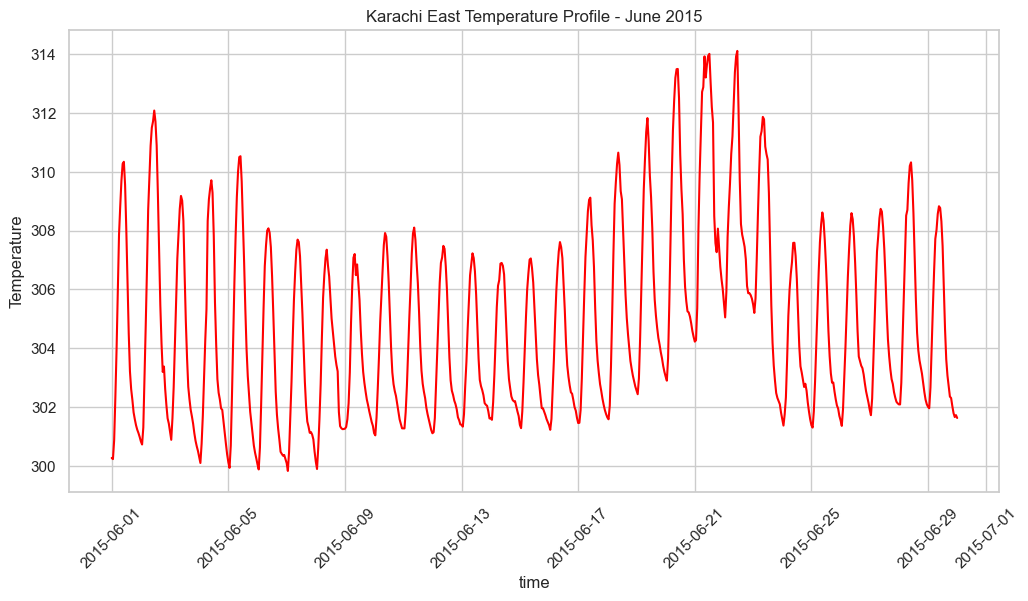

Look for a massive spike around June 17-24.


In [59]:
print("--- 5. HISTORICAL CHECK: JUNE 2015 HEATWAVE ---")

# Filter for a major city (e.g., Karachi or Lahore) during the 2015 Heatwave
target_district = "Karachi East"  # Could have gone with Karachi West as well
start_date = "2015-06-01"
end_date = "2015-06-30"

# Filter data
mask = (df['district_name'] == target_district) & \
       (df['time'] >= start_date) & \
       (df['time'] <= end_date)
heatwave_df = df[mask]

if heatwave_df.empty:
    print(f"⚠️ No data found for {target_district} in June 2015. Check spelling?")
else:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=heatwave_df, x='time', y='temp_2m', color="red")
    plt.title(f"{target_district} Temperature Profile - June 2015")
    plt.xticks(rotation=45)
    plt.ylabel("Temperature")
    plt.show()
    print("Look for a massive spike around June 17-24.")